In [16]:
import requests as r 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import csv
import json
from tensorflow import keras

In [60]:
for att in dir(keras.preprocessing.sequence):
    print(att)

TimeseriesGenerator
__builtins__
__cached__
__doc__
__file__
__loader__
__name__
__package__
__path__
__spec__
_sys
make_sampling_table
pad_sequences
skipgrams


In [2]:
df=pd.read_csv('/home/edugonik/Documents/git/tp_curso_ml/src/pickle/datasets/extract.tab', sep = '\t')
df.columns

Index(['Entry', 'Entry name', 'Status', 'Protein names', 'Gene names',
       'Organism', 'Length', 'Binding site', 'Function [CC]', 'Metal binding',
       'Nucleotide binding', 'Site', 'Annotation', 'Gene names  (ORF )',
       'Sequence', 'Developmental stage', 'Tissue specificity',
       'Gene ontology (molecular function)',
       'Gene ontology (cellular component)', 'Coiled coil',
       'Compositional bias', 'Protein families', 'Organism ID',
       'Gene ontology IDs', 'Intramembrane', 'Subcellular location [CC]',
       'Topological domain', 'Transmembrane'],
      dtype='object')

In [3]:
transmembrana = df.dropna(subset=['Transmembrane'])

In [4]:
def random_selection_dataframe(dataframe: pd.DataFrame, length:int)-> pd.DataFrame:
    dataframe.reset_index(drop=True, inplace=True)
    selected_indeces=np.random.choice(a=dataframe.index, size=length, replace=False)
    return dataframe.iloc[selected_indeces,:]

In [5]:
n_residuos_tm=lambda row:len(re.findall(r"(TRANSMEM \d+(..)\d+;)",row['Transmembrane']))
n_residuos_tm_np=np.vectorize(lambda datum:len(re.findall(r"(TRANSMEM \d+(..)\d+;)",datum)))

In [6]:
set_todos=set(df.Entry)
set_transmembrana=set(transmembrana.Entry)

In [7]:
set_no_transmembrana=set_todos - set_transmembrana
no_transmembrana=df[df.Entry.isin(set_no_transmembrana)]

In [44]:
sel_nt=random_selection_dataframe(no_transmembrana[['Sequence','Transmembrane']], transmembrana.shape[0]).to_numpy()
sel_t=transmembrana[['Sequence', 'Transmembrane']].to_numpy()
sel_t[:,1]=n_residuos_tm_np(sel_t[:,1])
sel_nt[:,1]=0
label=np.vstack([np.ones((sel_t.shape[0],1)), np.zeros((sel_nt.shape[0],1))])
data=np.vstack([sel_t,sel_nt])
data.shape

(157710, 2)

In [45]:
allchars=set()
for n,node in enumerate(data[:,0]):
        for char in node:
            allchars.add(char)

In [10]:
codigo_numerico={}
for n,char in enumerate(allchars):
    codigo_numerico[char]=n
with open('codigo_numerico.json', 'w') as file:
    json.dump(codigo_numerico, file)

[]

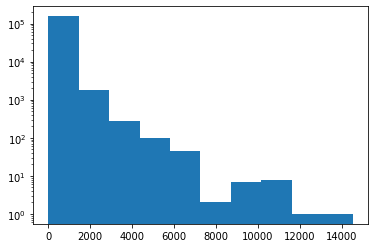

In [22]:
plt.hist(np.vectorize(len)(data[:,0]))
plt.semilogy()

In [46]:
data=data[np.vectorize(len)(data[:,0]) < 2000] #Solo incluyo secuencias menores a 2000 pb

In [54]:
numeric_nodes=[]
for node in data[:,0]:
    numeric_nodes.append(keras.preprocessing.sequence.pad_sequences(np.array([codigo_numerico[char] for char in node], dtype=int).reshape(1,-1), 2000))
seqs=np.vstack(numeric_nodes)
transmembrane_domains=data[:,-1]

In [62]:
np.savez('/home/edugonik/Documents/git/tp_curso_ml/src/pickle/numpy_arrays/data.npz', seqs=seqs, transmembrane_domains=transmembrane_domains)